# Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import torch

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
!pip install xgboost
from xgboost import XGBClassifier

from transformers import BertTokenizer, BertModel

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 1.3 MB/s eta 0:00:00


# Downsampling the dataset

In [ ]:
import pandas as pd
df_ = pd.read_csv('/content/drive/MyDrive/Sentiment_analysis/Combined Data.csv')

min_class_size = df_['status'].value_counts().min()
print(f"Size of the minority class: {min_class_size}")

df_classes = []
for status in df_['status'].unique():
  df_classes.append(df_[df_['status'] == status])

undersampled_df_classes = []
for class_df in df_classes:
  if len(class_df) > min_class_size:
    undersampled_df_classes.append(class_df.sample(min_class_size, random_state=42))
  else:
    undersampled_df_classes.append(class_df)

df = pd.concat(undersampled_df_classes)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nClass distribution after undersampling:")
print(df['status'].value_counts())

Size of the minority class: 1201

Class distribution after undersampling:
status
Bipolar                 1201
Personality disorder    1201
Suicidal                1201
Normal                  1201
Stress                  1201
Depression              1201
Anxiety                 1201
Name: count, dtype: int64


# Dataset Preprocessing

In [ ]:
def clean_text(text):

    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text) # Remove URLs (including markdown-style links)
    text = re.sub(r'<.*?>+', '', text) # Remove HTML tags
    text = re.sub(r'@\w+', '', text) # Remove handles (that start with '@')
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation and other special characters
    text = re.sub(r'\n', ' ', text) # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces

    return text.strip()

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df['statement'] = df['statement'].str.lower()

df['statement'] = df['statement'].apply(clean_text)
stopWords = stopwords.words('english')
df['statement'] = df['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWords)]))

# Exploratory Data Analysis (EDA)

In [ ]:
df

,Unnamed: 0,statement,status
0,45700,bought new phone didn’t need one don’t know th...,Bipolar
1,51490,pms avpd feeling okay quite im hyperfocusing t...,Personality disorder
2,51142,gender rules amp relationship avoidant guy don...,Personality disorder
3,36155,donât hate player hate game jess glynne prob...,Suicidal
4,31371,lot better paying someone,Normal
...,...,...,...
8198,49108,don’t know i’m supposed god past months horrib...,Stress
8199,29819,fear fainting like “what fainted much fear tes...,Stress
8200,30125,sent fullblown crisis breaking open “no one be...,Stress
8201,52577,able cut sugar md tells cut sugar body run wit...,Anxiety


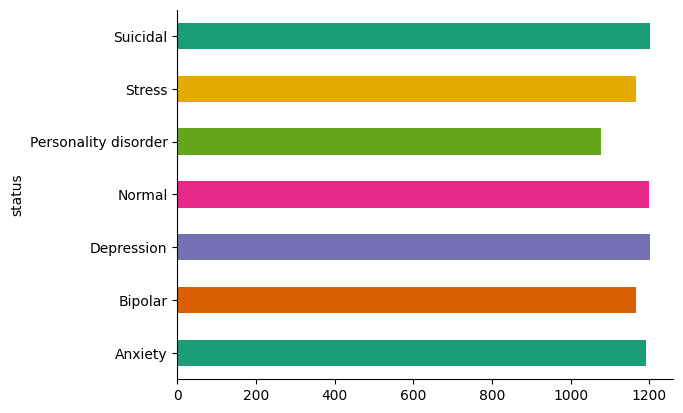

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203 entries, 0 to 8202
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8203 non-null   int64 
 1   statement   8203 non-null   object
 2   status      8203 non-null   object
dtypes: int64(1), object(2)
memory usage: 192.4+ KB


In [ ]:
df.status.value_counts()

,count
status,
Suicidal,1201
Depression,1201
Normal,1200
Anxiety,1191
Bipolar,1167
Stress,1166
Personality disorder,1077


In [ ]:
_status = df['status'].unique()

for i in _status:
  print(df[df['status'] == i].iloc[0, 1],)
  print(df[df['status'] == i].iloc[0, 0])
  print('\n','---'* 50)

bought new phone didn’t need one don’t know thinking going get perfectly functional iphone se new accessories ended walking store instead still don’t feel pinch yet im sure i’ll regret later
45700

 ------------------------------------------------------------------------------------------------------------------------------------------------------
pms avpd feeling okay quite im hyperfocusing things make happy brain busy think negative things however know fact avpd gets significantly worse period approaching mood plummets entirely start becoming really mistrustful peoples intentions isolate completely lose hope future theres also really important exam coming soon really want head game rather worrying much terrible failure everyone actually pretends tolerate would rather gone lives advice anyone good strategy dealing pms avpd time
51490

 ------------------------------------------------------------------------------------------------------------------------------------------------------


# Label Encoding

In [ ]:
labelEnconder = LabelEncoder()
df['status'] = labelEnconder.fit_transform(df['status'])


labels = labelEnconder.classes_

# Dataset Splitting

In [ ]:
X = df['statement']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Vectorization using TF-IDF method

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Training the XGBoost model

In [ ]:
xgb = XGBClassifier(learning_rate=0.2, max_depth=4, n_estimators=100, random_state=101,  tree_method='hist') # Changed to CPU method

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb.predict(X_test)

# Evaluation of XGBoost model

Accuracy: 0.7172455819622182
                      precision    recall  f1-score   support

             Anxiety       0.75      0.74      0.74       242
             Bipolar       0.92      0.78      0.84       249
          Depression       0.60      0.54      0.57       223
              Normal       0.74      0.90      0.81       268
Personality disorder       0.78      0.73      0.75       215
              Stress       0.64      0.62      0.63       222
            Suicidal       0.60      0.67      0.63       222

            accuracy                           0.72      1641
           macro avg       0.72      0.71      0.71      1641
        weighted avg       0.72      0.72      0.72      1641



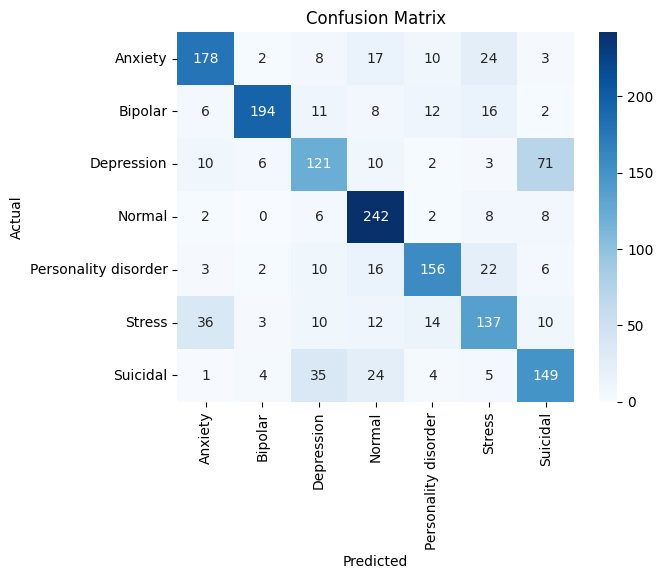

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=labels))

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')
plt.show()

# End to end pipeline of training and evaluation of BERT model

In [ ]:
# 1. Install required libraries
!pip install transformers datasets scikit-learn torch

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# 2. Load and preprocess data
df = pd.read_csv("/content/drive/MyDrive/Sentiment_analysis/Combined Data.csv")
df = df[['statement', 'status']].dropna()


# downsampling the dataset based on the least number of data points in a class
min_class_size = df['status'].value_counts().min()
print(f"Size of the minority class: {min_class_size}")

df_classes = []
for status in df['status'].unique():
  df_classes.append(df[df['status'] == status])

undersampled_df_classes = []
for class_df in df_classes:
  if len(class_df) > min_class_size:
    undersampled_df_classes.append(class_df.sample(min_class_size, random_state=42)) # Using random_state for reproducibility
  else:
    undersampled_df_classes.append(class_df)

df = pd.concat(undersampled_df_classes)

# Shuffle the downsampled dataframe
df= df.sample(frac=1, random_state=42).reset_index(drop=True)


# 3. Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['status'])

# 4. Train/test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 5. Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['statement', 'label']])
test_dataset = Dataset.from_pandas(test_df[['statement', 'label']]) # Corrected line


# 6. Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# 7. Tokenization function
def tokenize(batch):
    return tokenizer(batch["statement"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# 8. Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 9. Load BERT model
num_labels = len(label_encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

# 10. Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# 11. Training arguments
training_args = TrainingArguments(
    output_dir="./distilbert-mental-health",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10, # Reduced number of epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# 12. Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 13. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 14. Train the model
trainer.train()

# 15. Evaluate
results = trainer.evaluate()
print("Evaluation results:", results)

# Get predictions on the test set to generate classification report
predictions = trainer.predict(test_dataset)
y_pred_bert = predictions.predictions.argmax(-1)
y_true_bert = predictions.label_ids

# Get class names
class_names = label_encoder.classes_

# Print classification report for each class
print("\nPerformance metrics for each class (BERT Model):")
print(classification_report(y_true_bert, y_pred_bert, target_names=class_names))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
Size of the minority class: 1077


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/6031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1508 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.740085,0.746021,0.734908,0.754889,0.746021
2,1.019600,0.585602,0.786472,0.785650,0.794646,0.786472
3,0.529300,0.555856,0.803714,0.803962,0.805872,0.803714
4,0.331400,0.644320,0.791114,0.791390,0.795565,0.791114
5,0.331400,0.722193,0.793103,0.792263,0.793442,0.793103
6,0.187300,0.834081,0.779178,0.780308,0.786249,0.779178
7,0.114700,0.916678,0.791114,0.790250,0.790431,0.791114
8,0.058400,0.977659,0.795756,0.795404,0.797003,0.795756
9,0.058400,1.016315,0.791777,0.791816,0.792016,0.791777
10,0.031800,1.032014,0.796419,0.796647,0.797063,0.796419


Evaluation results: {'eval_loss': 0.5558555722236633, 'eval_accuracy': 0.8037135278514589, 'eval_f1': 0.8039623138446308, 'eval_precision': 0.8058719077004989, 'eval_recall': 0.8037135278514589, 'eval_runtime': 0.8542, 'eval_samples_per_second': 899.098, 'eval_steps_per_second': 28.097, 'epoch': 10.0}

Performance metrics for each class (BERT Model):
                      precision    recall  f1-score   support

             Anxiety       0.83      0.86      0.84       215
             Bipolar       0.92      0.83      0.87       215
          Depression       0.68      0.67      0.68       215
              Normal       0.91      0.89      0.90       216
Personality disorder       0.86      0.87      0.86       216
              Stress       0.73      0.83      0.78       215
            Suicidal       0.71      0.68      0.70       216

            accuracy                           0.80      1508
           macro avg       0.81      0.80      0.80      1508
        weighted avg     